# Component Failure Predictive Final Project 

This work is positioned in the discipline of Data Science with utility to the place of predictive maintenance. The want to have a way to determine whether or no longer a particular laptop will fail, as well as the nature of the failure, is essential for era 4 industries. The primary motive lies at the back of the following consideration: the repair or substitute of a erroneous machine commonly requires expenses that are a great deal greater than those required for the substitute of a single component. Therefore, the set up of sensors that screen the country of the machines, amassing the splendid information, can lead to magnificent savings for industries.

Here we use the AI4I Predictive Maintenance Dataset from the UCI Repository to lift out an evaluation that ambitions to reply to the desires just reported. In particular, the work is through a lineup that signify a regular Machine Learning application. In the first place the dataset is explored to obtain a deeper information that can guide in entirely grasp the ground truth. Then, some preprocessing techniques are utilized to prepare the statistics for the algorithms we will use to make our predictions. We think about two major tasks: the first consists in setting up whether or not a regularly occurring desktop is about to go through a failure while the 2nd issues the willpower of the nature of the fault. Finally, a comparison is provided between the outcomes obtained with the aid of the latter, evaluating each their performance thru appropriate metrics, and their interpretability.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
original_data=pd.read_csv("component_failure_prediction.csv")

In [3]:
data=original_data.copy()
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')#converting numeric to float

data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)# Rename features

We deal with the two ID columns before moving on to more technical topics since it is impractical to believe that a machine's failure is dependent on its identifier and because the model we will employ may become confused by them. But even if UDI turns out to be a copy of the dataframe index, the Product ID column consists of five integers after the first letter; there's a slim possibility that this arrangement conceals a secret pattern. It is possible to verify that the Product ID column is legitimate and does not genuinely contain any further information beyond the feature Type, though, because the first letter corresponds to the machine type and the number sequences establish three intervals based on the same feature.

In [6]:
data['Product ID'] = data['Product ID'].apply(lambda x: x[1:])
data['Product ID'] = pd.to_numeric(data['Product ID'])#converting to numeric  

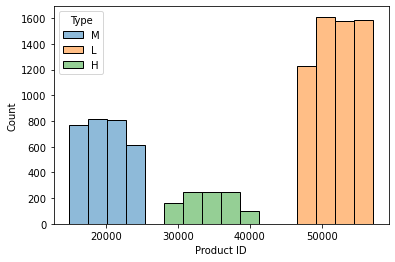

In [7]:
# Histogram of ProductID
sns.histplot(data=data, x='Product ID', hue='Type')
plt.show()

In [8]:
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)# Drop ID columns

The following pie chart shows the percentages of machines by Type:


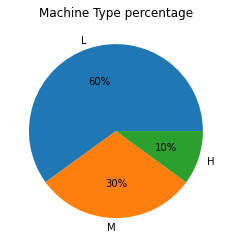

In [9]:
# Pie chart of Type percentage
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

Before splitting the dataset, we look at the target distribution in this part to identify any imbalances and fix them. The first anomaly with regard to the description of the dataset is that the Machine Failure feature is not set to 1 when the failure is random (RNF).

In [10]:
#list of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']

idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [11]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


Removing these rows is our choice because, fortunately, machine failure RNF only happens in 18 observations and is random in nature, making it unpredictable.

In [12]:

idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


Going forward we find out that in 9 observations Machine failure is set to 1 when all types of failures are set to 0. We cannot understand if there really was a failure or not so let’s remove these observations too.

In [13]:
print('Global percentage of removed observations:',
     (100*(first_drop+second_drop)))
df.reset_index(drop=True, inplace=True)  
n = df.shape[0]#total removed observation

Global percentage of removed observations: 2700


Our actions did not alterate the original data very much.

In [14]:
##Inspection of outliers 

This section's objective is to determine whether the dataset has any outliers, which are typically deceptive to machine learning systems. A statistical report of the numerical aspects is what we first examine.

In [15]:
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


Because the rotational speed and torque maximum diverge significantly from the third quartile, we can infer the presence of outliers in this data. We examine more closely at the boxplot scenario, use histograms to comprehend the distribution, in order to give this idea more tangible context.

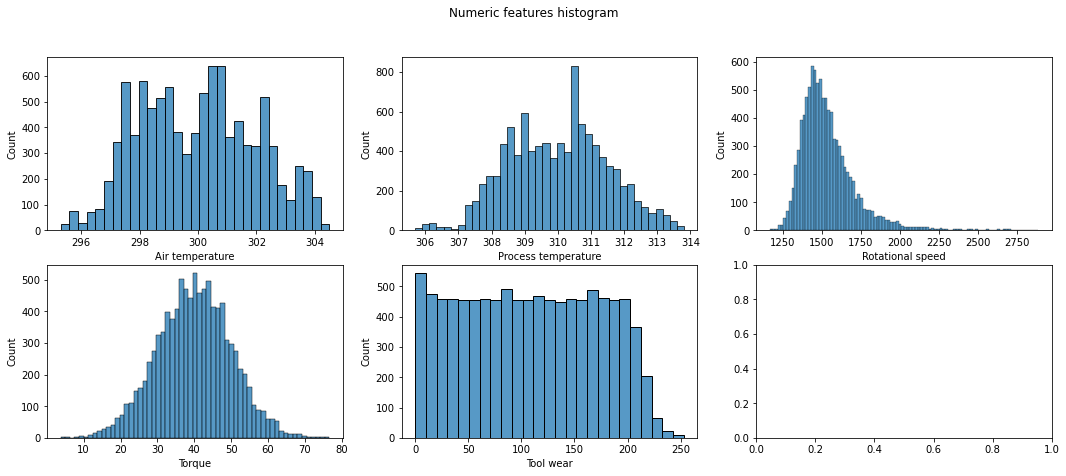

In [16]:
num_features = [feature for feature in features if df[feature].dtype=='float64']
# Histogram
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()



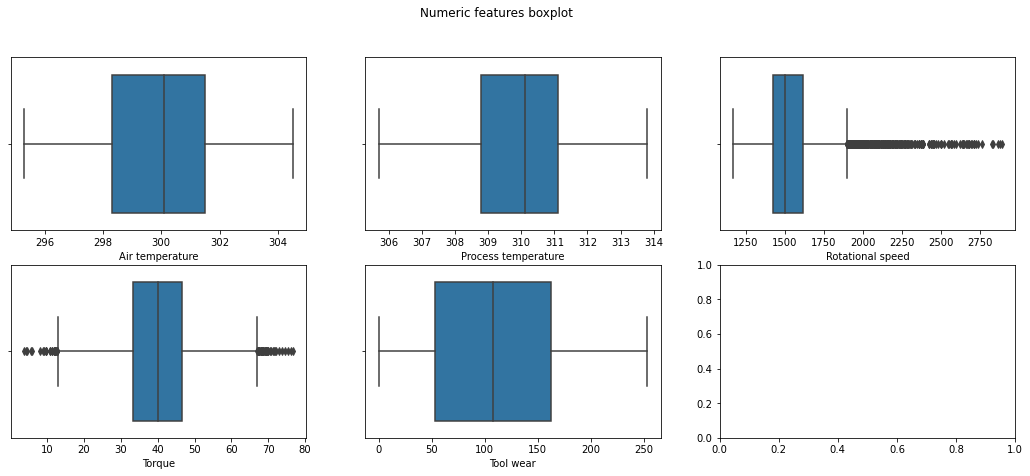

In [17]:
# boxplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

The boxplots indicate potential outliers in the features listed above. For Torque, these can likely be traced back to the boxplot method of outlier detection (the Gaussian distribution makes using the 3σ rule instead of the IQR more appropriate); for Rotational Speed, the Gaussian distribution is skewed, so it is not implausible to assume that the few observations with high Rotational Speed will fail. We therefore retain the outliers for the time being and reserve the right, after taking other factors into account, to determine whether or not to act on them.

# Using SMOTE for Resampling 

An other crucial factor to take into account is the remarkably low percentage of machine failures (3.31%) across the entire dataset. Furthermore, an additional degree of imbalance is revealed by a pie plot that displays the incidence of the contributing factors to each failure.

Failures percentage in data: 3.31


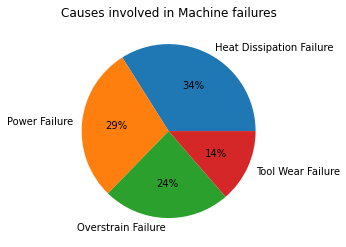

In [18]:
# Portion of df where there is a failure and causes percentage
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

An imbalance of classes is a major worry when working with machine learning problems since it can cause confusion in the training process of the models as well as in our understanding of their output. For example, if we use this dataset to create a model that says machines never break, it should be 97% accurate. To mitigate these impacts and restrict the models' favored behavior concerning specific classes, we conduct data augmentation. Our objective is to achieve an 80/20 ratio between accurate and inaccurate observations, as well as an equal percentage of occurrence between the reasons contributing to the failures.

In [19]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

 Comparison after resampling

Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


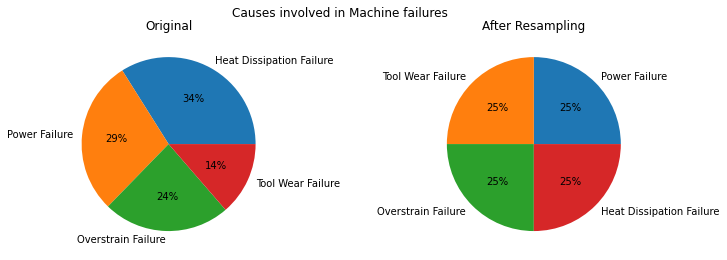

In [20]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

As one can expect, the cases of Machine Failure mainly concern low quality machines, then those of medium quality and only a few times those of high quality. This difference is accentuated when the number of observations of non-functioning machines is (artificially) increased. However, from the kdeplots below it can be seen that this is not widely correlated with the features since differentiating according to the quality shows that distribution of the features does not present big differences, except for the two side peaks in Tool Wear (which is consistent with the data description). This suggests that probably the fact that the majority of failures concern type L machines is due to the greater presence of this type in the dataset and therefore that the correlation with the failure of the machine is due to statistical reasons.

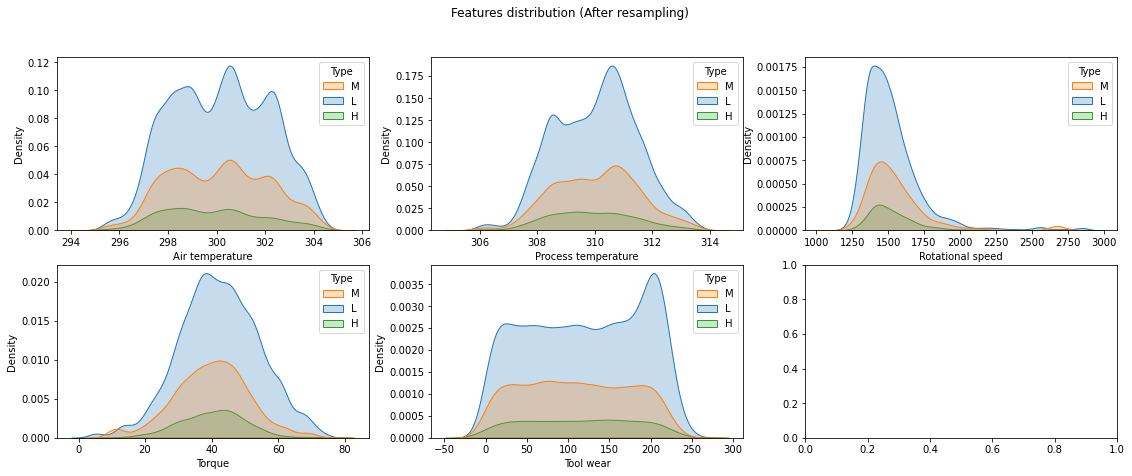

In [21]:
# Kdeplot of numeric features (After resampling) - hue=Type
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,7))
fig.suptitle('Features distribution (After resampling)')
custom_palette = {'L':'tab:blue', 'M':'tab:orange', 'H':'tab:green'}
for j, feature in enumerate(num_features):
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
              hue='Type', fill=True, palette=custom_palette)
plt.show()

Let's now examine how the distribution of features has evolved.

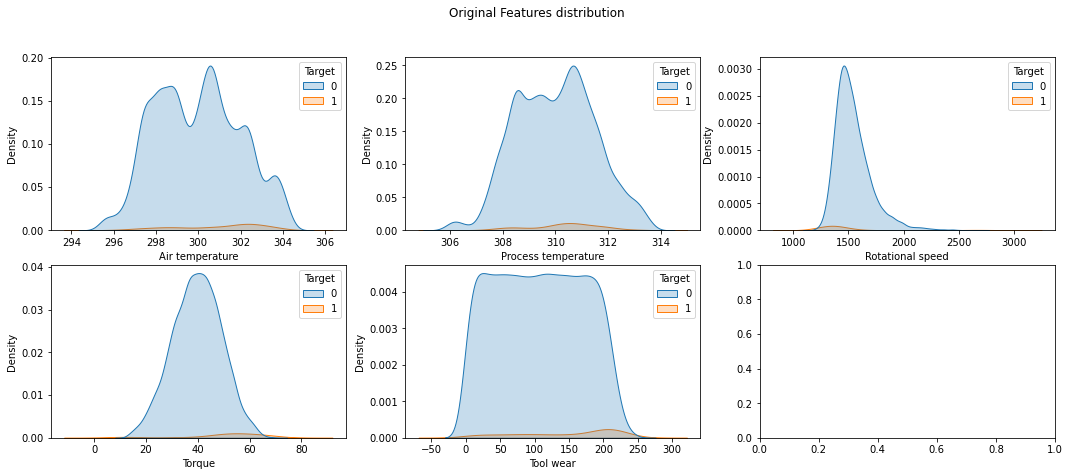

In [22]:
# Kdeplot of numeric features (Original)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Original Features distribution')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature,
                hue='Target', fill=True, palette='tab10')
plt.show()



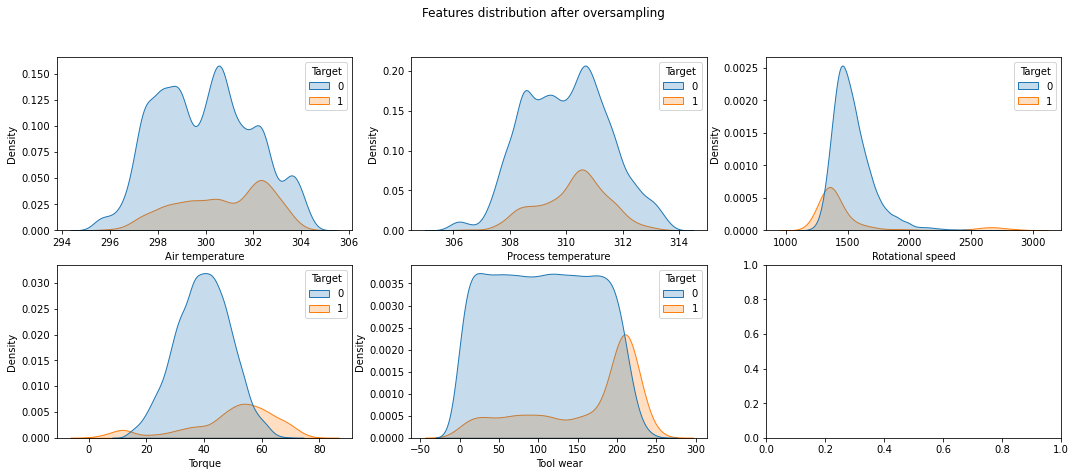

In [23]:
# Kdeplot of numeric features (After resampling)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Target'], fill=True, palette='tab10')
plt.show()

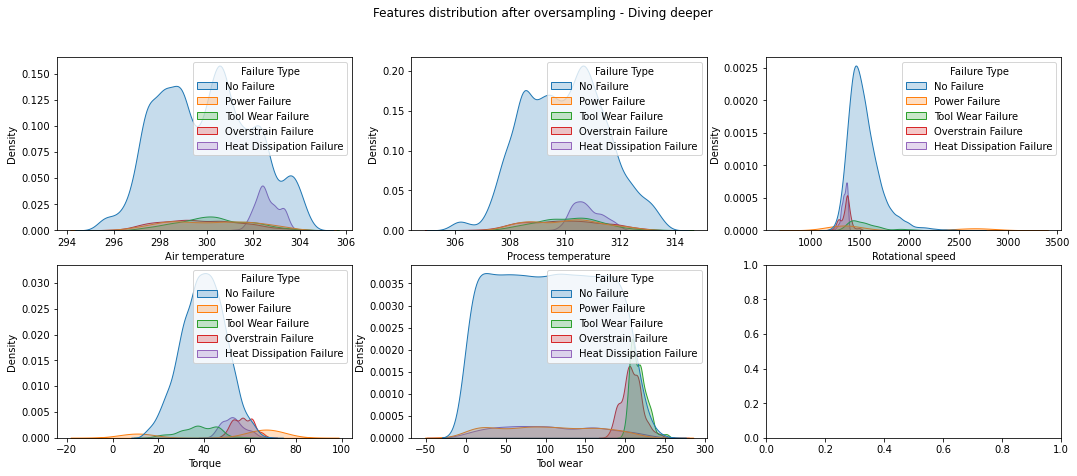

In [24]:
# Kdeplot of numeric features (After resampling) - Diving deeper
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling - Diving deeper')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Failure Type'], fill=True, palette='tab10')
plt.show()

 The first thing we can observe is that the data augmentation was successful because the feature distribution of the faulty instances was not  significantly skewed.
 It should also be noted that the observation of failures in speed, torque, and tool wear shows density peaks in the  extreme zones of the distribution.
 This means that the outliers described above are due to the natural distribution of the dataset, rather than due to errors in the creation of the dataset.
 This becomes even clearer when considering the distribution associated with individual failure causes.
 In particular, we see an almost symmetrical behavior with respect to speed and torque, but with respect to tool wear, a clear separation  between PWF and HDF failures is observed at lower values.
 A peak can be seen at a higher value than TWF and OSF.
 This is fully consistent with the goal description provided in the Task and Dataset Description section.



Features scaling and Encoding

The mapping follows this scheme: Type: {L=0, M=1, H=2} Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4} 
Secondly we perform the scaling of the columns with StandardScaler.
It has been also verified that using StandardScaler leads to slightly better performances than using MinMaxScaler.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

#PCA and Correlation Heatmap

We run PCA to have a further way of displaying the data instead of making feature selection.

In [26]:
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per component:
PC1    37.69
PC2    36.81
PC3    19.84
PC4     3.08
PC5     2.58
dtype: float64
Explained variance ratio with 3 components: 94.34


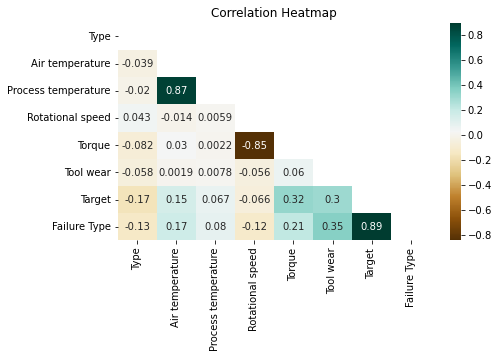

In [27]:
# Correlation Heatmap
plt.figure(figsize=(7,4))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

Not unexpectedly, we find that there is a strong correlation between the temperature and power features. Additionally, Tool Wear confirms what we have seen from using PCA and has a strong correlation with both of our targets. Lastly, a weaker association between the two objectives and the torsion is also noted.

In [28]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [29]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time

In [30]:
# train-validation-test split
X, y = df_pre[features], df_pre[['Target','Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

In [31]:
def eval_preds(model,X,y_true,y_pred,task):
    if task == 'binary':
        # Extract task target
        y_true = y_true['Target']
        cm = confusion_matrix(y_true, y_pred)
        # Probability of the minority class
        proba = model.predict_proba(X)[:,1]
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    elif task == 'multi_class':
        y_true = y_true['Failure Type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
    metrics = round(metrics,3)
    return cm, metrics



def tune_and_fit(clf,X,y,params,task):
    if task=='binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                                cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Target'])
    elif task=='multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                              cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Failure Type'])
        
    print('Best params:', grid_model.best_params_)
    # Print training times
    train_time = time.time()-start_time
    mins = int(train_time//60)
    print('Training time: '+str(mins)+'m '+str(round(train_time-mins*60))+'s')
    return grid_model




def predict_and_evaluate(fitted_models,X,y_true,clf_str,task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models,clf_str):
        # Update predictions
        y_pred[model_name] = fit_model.predict(X)
        # Metrics
        if task == 'binary':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        # Update Confusion matrix and metrics
        cm_dict[model_name] = cm
        metrics[model_name] = scores
    return y_pred, cm_dict, metrics





def fit_models(clf,clf_str,X_train,X_val,y_train,y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train,y_train['Target'])
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model,X_val,y_val,y_val_pred,'binary')[1]
    return metrics

Feature selection attempts :
Before training the mentioned models, we perform feature selection based on the correlation heatmap and exploratory data analysis. The correlation analysis revealed a positive correlation between "Process temperature" and "Air temperature", while "Torque" and "Rotational speed" showed a negative correlation. Furthermore, the dataset description indicates that PWF failure occurs when the product of "Torque" and "Rotational speed" falls within a specific range, and HDF failure occurs if the difference between "Air temperature" and "Process temperature" exceeds a certain threshold. Because of the potential loss of important information, deleting these columns completely appears unwise. However, it is sensible to experiment with combining them in pairs to create meaningful new features. Hence, we compare the results of fitting classification models without parameter tuning on the mentioned datasets.

-the original one;
-the one obtained by removing the "Process temperature" and "Air temperature" columns, replacing them with a column of their product;
-the one obtained by removing "Torque" and "Rotational speed", replacing them with a column of their product;
-a combine the previous operations.

In [32]:
# Models
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier() 





In [33]:
clf = [lr,knn,svc,rfc,xgb]
clf_str = ['LR','KNN','SVC','RFC','XGB'] 

# Fit on raw train
metrics_0 = fit_models(clf,clf_str,X_train,X_val,y_train,y_val)


In [34]:
# Fit on temperature product train
XX_train = X_train.drop(columns=['Process temperature','Air temperature'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature'] = X_val['Process temperature']*X_val['Air temperature']
metrics_1 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

In [35]:
# Fit on power product train
XX_train = X_train.drop(columns=['Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Rotational speed','Torque'])
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']     
metrics_2 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)


In [36]:
# Fit on both products train
XX_train = X_train.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']*X_val['Air temperature']
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']       
metrics_3 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

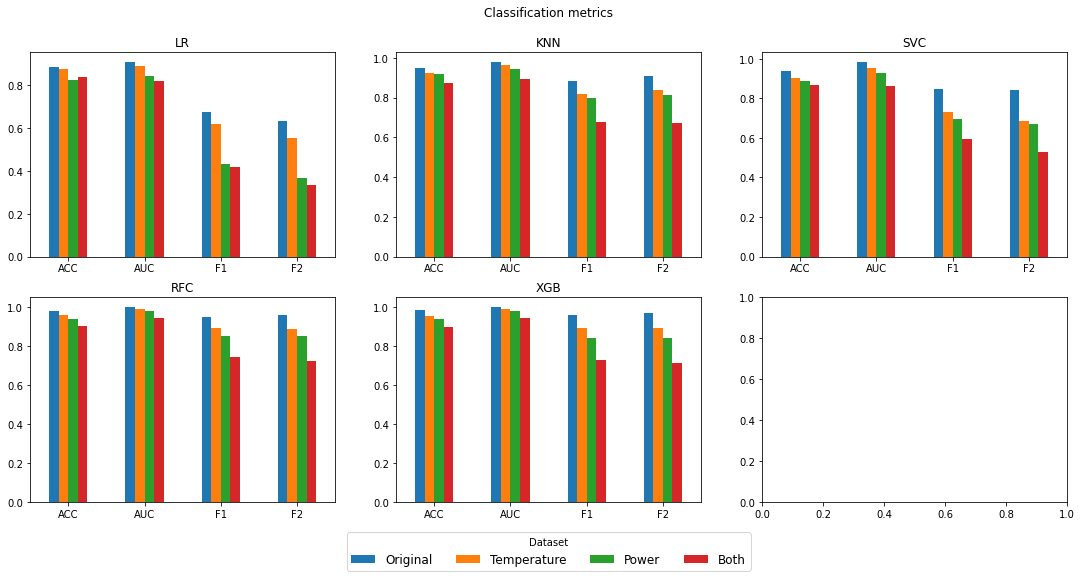

In [37]:
# classification metrics barplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')
for j, model in enumerate(clf_str):
    ax = axs[j//3,j-3*(j//3)]
    model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],metrics_2[model],metrics_3[model]])
    model_metrics.index = ['Original','Temperature','Power','Both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0, )
    ax.title.set_text(model)
    ax.get_legend().remove()
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center',
                         bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()

From the results obtained, we observe that all the models applied to the entire dataset perform better than when they are applied to the ones created by reducing the number of features. The best performances and the modest number of features from which our dataset is composed encourage us to opt to avoid the feature selection step.

# Logistic Regression Benchmark 
We decide to use Logistic Regression as a Benchmark for our task. It represents an intermediate step between the basic model referred above in Resampling with SMOTE and the more complex models that we have described and we will explore in depth in the following sections. Now we look at the results obtained and at the interpretability of the model.

In [38]:
# Make predictions
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['Target'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'binary')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

Validation set metrics:
ACC    0.883
AUC    0.905
F1     0.673
F2     0.629
dtype: float64
Test set metrics:
ACC    0.881
AUC    0.917
F1     0.655
F2     0.598
dtype: float64


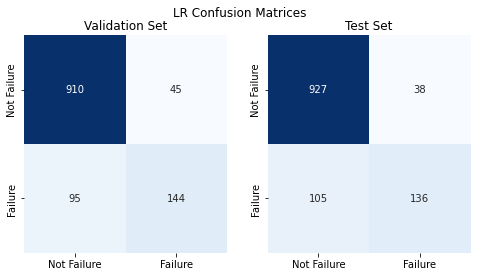

In [39]:
cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

In [40]:
# Odds for interpretation
d = {'feature': X_train.columns, 'odds': np.exp(lr.coef_[0])}
odds_df = pd.DataFrame(data=d).sort_values(by='odds', ascending=False)
odds_df

,feature,odds
4,Torque,16.696209
3,Rotational speed,9.394822
1,Air temperature,4.462500
5,Tool wear,3.483306
0,Type,0.520599
2,Process temperature,0.348815


The odds of logistic regression allow us to understand how the model is working. In instance, rotational speed and torque are assigned unnecessarily high weight. This is mostly because these features have a natural variance that tends to "deviate" the model and is particularly high when examining solely the failed situations. On the basis of exploratory study, it is acceptable to assume that the first four features are much more relevant than the latter two. When we apply logistic regression to the multiclass task, we likewise anticipate higher odds values because the effects that are distributed here seem to be concentrated around specific kinds of failures.

# Models

In [41]:
# Models
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier() 
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

# Parameter grids for GridSearch
knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[300,500,700],
              'max_depth':[5,7],
              'learning_rate':[0.01,0.1],
              'objective':['binary:logistic']}
params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                   index=clf)

# Tune hyperparameters with GridSearch (estimated time 8m)
print('GridSearch start')
fitted_models_binary = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'binary')
    fitted_models_binary.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 5s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 5m 22s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 5m 18s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, 'objective': 'binary:logistic'}
Training time: 1m 53s


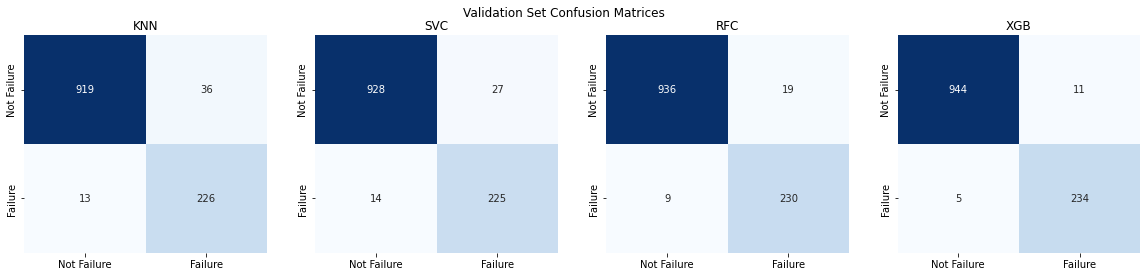

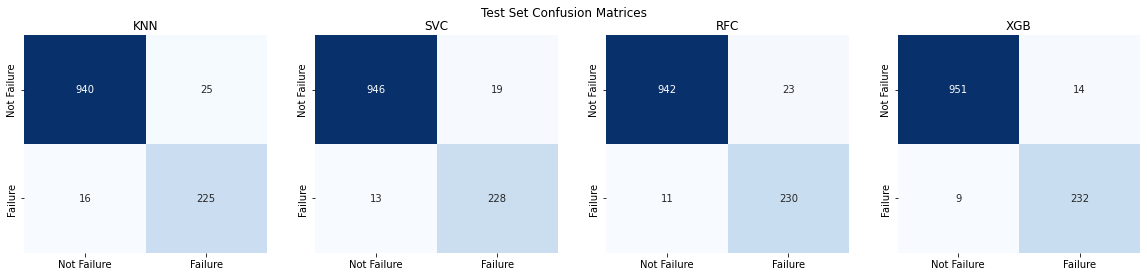


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.959  0.966  0.977  0.987
AUC  0.954  0.987  0.997  0.999
F1   0.902  0.916  0.943  0.967
F2   0.928  0.931  0.954  0.974
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.966  0.973  0.972  0.981
AUC  0.954  0.992  0.997  0.998
F1   0.916  0.934  0.931  0.953
F2   0.927  0.941  0.945  0.959


In [42]:
# Create evaluation metrics
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

All the selected models obtain similar results on the validation set (except KNN which is a little worse) and it is diffj7icult to determine if one works better than another by looking only at these values. Performance did not significantly drop when passing the test set, showing that overfitting was avoided. We comment on the results of the models by looking at the confusion matrices and the metrics obtained on the test set: in this way the formation of a hierarchy between the models used is slightly clearer, as all the metrics relating to a single model are smaller or larger than to the others and the time needed to search for the parameters is comparable, with the only exception of KNN. In particular KNN obtains the worst performances and XGB the best ones; in the middle we find SVC and RFC which achieve extremely similar results.

About the parameters:

   * A Gridsearch has been started on the parameters which, looking in the literature, appear to be preponderant for each specific model;
   * The grid values to search for have been defined on the basis of literature and various tests, trying to keep the computational cost of finding the best values moderate.


It is interesting to observe that the optimal parameters for RFC and XGB are the polar opposite: the former prefers to use a few estimators and go into depth while the latter uses more estimators with fewer splits. Furthermore, it must be taken into account that although XGB is the best classifier from a quantitative point of view, this is not true for what concerns the qualitative side. Both SVC and XGB in fact lack clear ways to interpret the results, while on the contrary RFC allows to have a complete understanding of how the algorithm worked. In any case, to get an idea of which features had greater importance in making the predictions, we report the permutation feature importances in a bar plot.

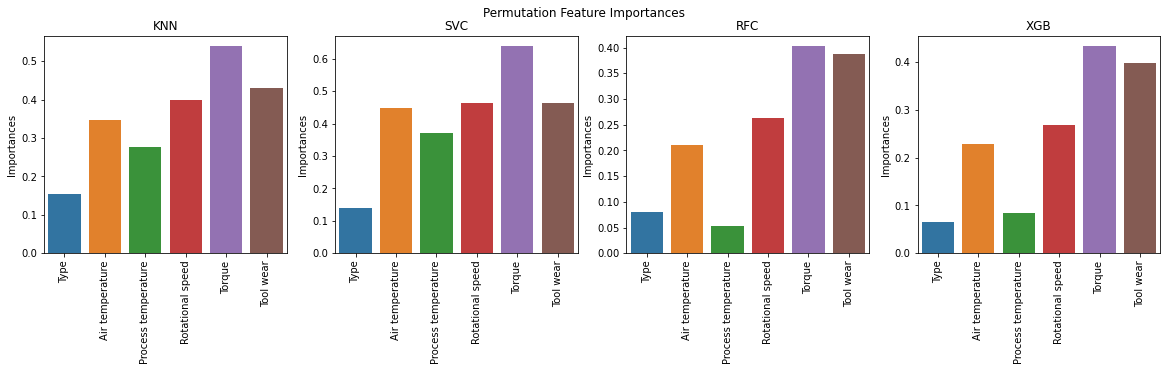

In [43]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
importances = pd.DataFrame()
for clf in fitted_models_binary:
    result = permutation_importance(clf, X_train,y_train['Target'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)
importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()


Remarks on Feature importances:

* Type is the feature with the lowest significance, in accordance with what was observed during the exploratory analysis. However, its importance remains strictly positive in each of the cases considered and therefore removing it completely would have led to a decline in prediction performance, not justified by a significant computational gain;
* Unlike Logistic Regression, the models tested place great emphasis on Tool wear as well as Torque and Rotational Speed. Since the former alone is related to a specific category of failures and strongly distorts the kdeplot of Machine failure, we have a sign that our models still worked well.

# Multi-class task


We are now moving on to the second job of this project, which is to forecast the type of failure that will occur in addition to its likelihood. Hence, we are dealing with multiclass classification issues where it is assumed that each sample has a single label. This theory is supported by the fact that during data preprocessing, any unclear observations that belonged to multiple classes were eliminated.

For multiclass targets, when we calculate the values of AUC, F1 and F2 scores, we need to set the parameter "average". We choose "average=weighted", in order to account for class imbalance: in fact, at the end of data preprocessing, we have 80% WORKING machine and 20% that fail. As for binary classification task, we choose Logistic Regression as baseline model and we look for models that get higher values for the chosen metrics. In particular, we adapt to the multiclass case the models developed in the previous section. While many classification algorithms (such as K-nearest neighbor, Random Forest and XGBoost) naturally permit the use of more than two classes, some (like Logistic Regression and Support Vector Machines) are by nature binary algorithms; these can, however, be turned into multiclass classifiers by a variety of strategies. For our project, we decide to use "OnevsRest" approach, who involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives. We choose it because it is computationally more efficient than other types of approach.

Validation set metrics:
ACC    0.926
AUC    0.983
F1     0.909
F2     0.919
dtype: float64
Test set metrics:
ACC    0.922
AUC    0.982
F1     0.904
F2     0.914
dtype: float64


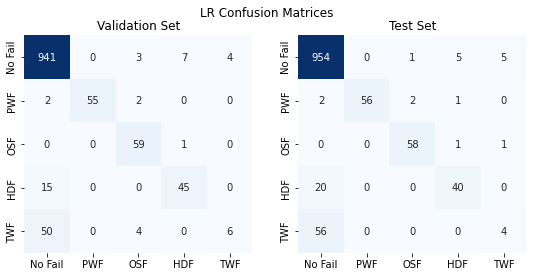

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
No Failure,1.920864,0.224090,2.866848,0.106442,0.059894,0.287084
Power Failure,0.697373,0.824558,0.982471,944.048373,2822.376842,0.744856
Tool Wear Failure,0.036806,0.215535,2.777322,0.108932,8.748803,406.189304
Overstrain Failure,0.636280,4314.687600,0.004253,0.000458,0.398540,0.711005
Heat Dissipation Failure,1.045501,1.337837,0.739732,0.225326,0.118551,749.948357


In [44]:
#First let’s look at how the Logistic Regression behaves:

# multiclass classification
lr = LogisticRegression(random_state=0,multi_class='ovr')
lr.fit(X_train, y_train['Failure Type'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Validation metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'multi_class')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'multi_class')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_lr = [cm_val_lr, cm_test_lr]
cm_labels = ['No Fail','PWF','OSF','HDF','TWF']
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(9,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

# Odds for interpretation
odds_df = pd.DataFrame(data = np.exp(lr.coef_), columns = X_train.columns,
                       index = df_res['Failure Type'].unique())
odds_df

In the table above there are, for every class, the Logistic Regression’s odds that explain the contribution of each feature in the prediction of belonging to a specific class. By comparing this table with the PCA scatter and the comments we made, we understand that there is a complete agreement about the features that most affect the type of failure. For example, if we look at odds’ values of PWF, we see that Rotational Speed and Torque are the ones that are most important for the forecast of belonging to this class. In the analysis of the PCA we stated that PWF seems to be dependent only on PC2, i.e. the Power that is the product of Rotational Speed and Torque. We can make similar considerations for other classes.



In [45]:
# Models
knn = KNeighborsClassifier()
svc = SVC(decision_function_shape='ovr')
rfc = RandomForestClassifier()
xgb = XGBClassifier()
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[100,300,500],
              'max_depth':[5,7,10],
              'learning_rate':[0.01,0.1],
              'objective':['multi:softprob']}

params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                    index=clf)


# Tune hyperparameters with GridSearch (estimated time 8-10m)
print('GridSearch start')
fitted_models_multi = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'multi_class')
    fitted_models_multi.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 5s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 6m 29s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 6m 3s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'objective': 'multi:softprob'}
Training time: 7m 16s


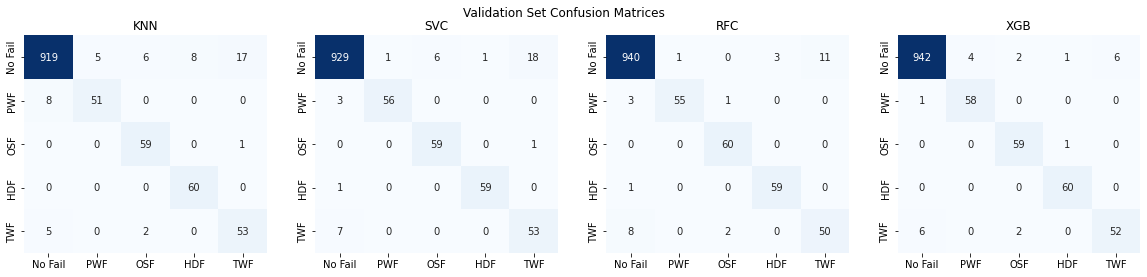

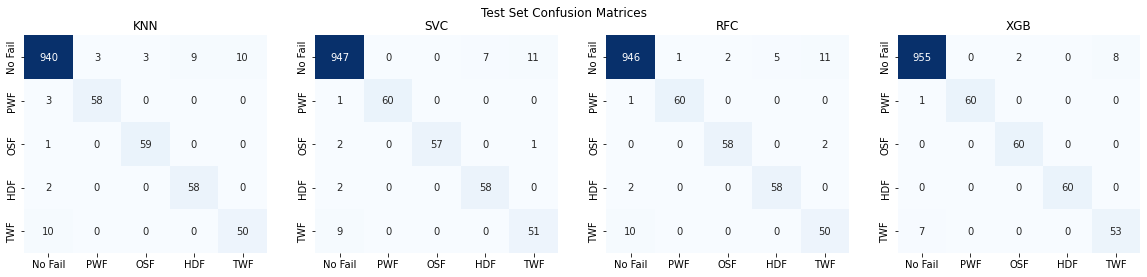


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.956  0.968  0.975  0.981
AUC  0.956  0.993  0.998  0.999
F1   0.957  0.969  0.975  0.981
F2   0.957  0.968  0.975  0.981
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.966  0.973  0.972  0.985
AUC  0.956  0.995  0.997  0.999
F1   0.966  0.973  0.972  0.985
F2   0.966  0.973  0.972  0.985


In [46]:
# Create evaluation metrics

task = 'multi_class'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_multi,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_multi,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

By comparing the results obtained, we see that K-NN is the model that performs the worst and its accuracy is a little lower than Logistic Regression’s one. Despite this, we cannot exclude it a priori, as it still reaches high values for the metrics and, moreover, gives an immediate response. So, we can use it whenever we need to get an idea quickly about the situation and, then apply other models when we have more time.

All other models perform better than the benchmark and they obtain high values for the chosen metrics both for validation and test set. SVC and RFC’s performances are very similar each other and XGB performs better than them. If we look at the training phase, SVC and RFC take the same time, while XGB takes more than four times as much as them. So, since, the improvement obtained with XGB is only 1.5%, one can choose which model he prefers according to his needs. While the best parameters for multiclass K-NN and SVC are the same as binary classification, for XGB and RFC the Gridsearch for the two types of task returns different parameters. Moreover, in the transition from binary to multiclass problem, the estimated training time remains the same for all models, except for XGB that triples it. In order to understand how features contribute to predictions, let’s look at the Permutation Feature Importances for each model.

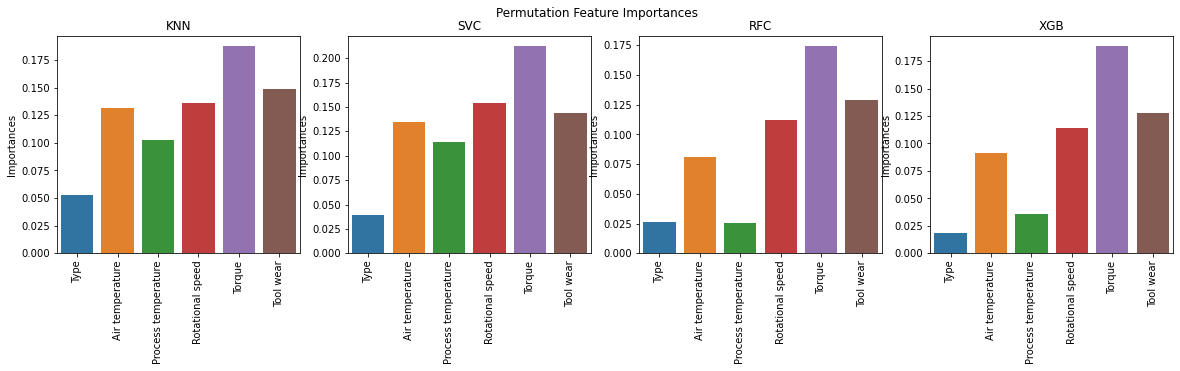

In [47]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
importances = pd.DataFrame()
for clf in fitted_models_multi:
    result = permutation_importance(clf, X_train,y_train['Failure Type'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)

importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()


From previous barplots we see that the models give more importance to Torque, Tool wear and Rotational Speed while the Type contribution is very low. This is in accordance with the observations made in the exploration of the dataset in Section 1-2 and it is consistent with the Permutation Feature Importances of binary task. K-NN is the one who gives more importance to Type, but, different from binary case, here we see that for every model the Type contribution is almost zero. So, we test the model on a new dataset, the old one from which we removed the column Type. For K-NN and SVC there is an insignificant improvement in the metrics’ values, which were already very good. For RFC and XGB we do not see any change on metrics’ values. Since the training time for the different models is approximately equal in both cases, we let users choose which dataset to use.

# Conclusions

Based on the conducted analysis and the acquired results, certain definitive conclusions regarding this project can be drawn.

We made the decision to take on two tasks: predicting the kind of failure that will transpire and determining whether a machine will fail or not. In order to guarantee the greatest performances and the validity of the model's application assumptions, we preprocessed the data before building the models. In summary, during the preprocessing stage, we eliminated a few unclear data, applied label encoding to the categorical columns, and then used StandardScaler to scale the columns. Additionally, we observed the existence of a few data points that, although initially labeled as outliers, later proved to be a significant component of the data's inherent variation and contributed significantly to the classification task. Then we ran PCA and found that most of the variance is explained by the first three components, that can be represented as the following features: combination of the two Temperatures, Machine Power (product of Rotational Speed and Torque) and Tool Wear. In according to this, we found that these are the features that contribute the most in the predictions when apply the models. Contrary to logical predictions, we demonstrated that the machine’s type does not affect the presence of failure.

At the end, we can conclude that for both task the chosen models perform very well. For both tasks the best model is XGBoost and the worst is KNN; however the response time of KNN is instant while XGBoost takes more time and this further increase when we proceed with the multi-class classification task. The choice of the model depends on the needs of the company: for faster application one can use KNN while if one cares more about accuracy one can use XGBoost.